# Lecture 14 - Advanced Curve Fitting: Gaussian Processes to Encode Prior Knowledge about Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

## Objectives

+ Express prior knowledge/beliefs about unknown functions using Gaussian process (GP).

+ Sample functions from the probability measure defined by GP.

## Readings

+ [Chapter 1 from C.E. Rasmussen's textbook on Gaussian processes](http://www.gaussianprocess.org/gpml/chapters/RW1.pdf).

+ (Optional video lecture) [Neil Lawrence's video lecture on Introduction to Gaussian processes](https://www.youtube.com/watch?v=ewJ3AxKclOg).

## Motivation: A fully Bayesian paradigm for curve fitting

Gaussian process regression is Bayesian regression on steroids.
However, understanding how it works requires a change of mind.
After a bit of practice it starts making sense.

Here is how it works:

+ Let's say that you have to learn some function $f(\cdot)$ from some space $\mathcal{X}$ to $\mathbb{R}$ (this could either be a supervised learning problem (regression or classification) or even an unsupervised learning problem.

+ You sit down and you think about $f(\cdot)$. What do you know about it? How large do you expect it be? How small do you expect it be? Is it continuous? Is it differentiable? Is it periodic? How fast does it change as you change its inputs?

+ You create a probability measure on the space of functions in which $f(\cdot)$ lives which is compatible with everything you know about it. Abusing mathematical notation a lot, let's write this probability measure as $p(f(\cdot))$. Now you can sample from it. Any sample you take is compatible with your prior beliefs. You cannot tell which one is better than any other. Any of them could be the true $f(\cdot)$.

+ Then, you get a little bit of data, say $\mathcal{D}$. You model the likelihood of the data, $p(\mathcal{D}|f(\cdot))$, i.e., you model how the data may have been generated if you knew $f(\cdot)$.

+ Finally, you use Bayes' rule to come up with your posterior probability measure over the space of functions:
$$
p(f(\cdot)|\mathcal{D}) \propto p(\mathcal{D}|f(\cdot)) p(f(\cdot)),
$$
which is simultaneously compatible with your prior beliefs and the data.
Again, we are abusing mathematical notation here since you cannot really write down the probability density corresponding to a random function.
But you get the point.

This is it.
As Persi Diaconis' said in an 1988 paper:

> Most people, even Bayesians, think that this sounds crazy when they first hear about it.

Where do **Gaussian processes** come in?
Well, it is just the equivalent of the multivariate Gaussian for function spaces.
It **defines a probability measure on the space of functions that is centered about a mean (function) and shaped by a covariance (function)**.
In this lecture, we will show that **the mean function and the covariance function is the place where you can encode your prior knowledge**.
We will also show how you can sample functions from this probability measure.
Next time, we will show how you can condition these probability measures on observations.

## Some mathematical terminology

A *stochatic process* is just a collection of random variables that are labeled by some index: $\{X_i\}$ for some $i$ in a set $I$.
If the set $I$ is discrete, then we say that we have a discrete stochastic process.
If the set $I$ is continuous, then we have a continuous stochastic process.
We will mostly work with continuous stochastic processes in this class.

For example, $X_t = X(t)$ is a stochastic process parameterized by time.
You can also think of a stochastic process as a random function.
Here is how, you sample an $\omega$, you keep it fixed, and then $X(t,\omega)$ is just a function of time. (Remember what we learned in earlier lectures: a random variable is just a function from the event space to the real numbers).

Of course, you can have a stochastic process that is parameterized by space, for example $T(x,\omega)$, could be an unknown temperature field.
This is typically called a random field.
You can also have a stochastic process that is parameterized by both space and time, say $T(x,t,\omega)$.
This is a unknown spatiotemporal temperature field.
As a matter of fact, you can have a stochastic process parameterized by any continuous label you like.
It does not have to be space or time.
And also, you can have as many different labels as you like.

**Gaussian processes are the simplest continuous stochastic processes you can have.**

## Gaussian process

A Gaussian process (GP) is a generalization of a multivariate Gaussian distribution to
*infinite* dimensions.
It essentially defines a probability measure on a function space.
When we say that $f(\cdot)$ is a GP, we mean that it is a random variable that is actually
a function.
Mathematically, we write:
\begin{equation}
f(\cdot) \sim \mbox{GP}\left(m(\cdot), k(\cdot, \cdot) \right),
\end{equation}
where 
$m:\mathbb{R}^d \rightarrow \mathbb{R}$ is the *mean function* and 
$k:\mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ is the *covariance function*.
So, compared to a multivariate normal we have:

+ A random function $f(\cdot)$ instead of a random vector $\mathbf{x}$.
+ A mean function $m(\cdot)$ instead of a mean vector $\boldsymbol{\mu}$.
+ A covariance function $k(\cdot,\cdot)$ instead of a covariance matrix $\mathbf{\Sigma}$.

But, what does this definition actually mean? Actually, it gets its meaning from the multivariate Gaussian distribution. Here is how: 

+ Let $\mathbf{x}_{1:n}=\{\mathbf{x}_1,\dots,\mathbf{x}_n\}$ be $n$ points in $\mathbb{R}^d$.
+ Let $\mathbf{f}\in\mathbb{R}^n$ be the outputs of $f(\cdot)$ on each one of the elements of $\mathbf{x}_{1:n}$, i.e.,
$$
\mathbf{f} =
\left(
\begin{array}{c}
f(\mathbf{x}_1)\\
\vdots\\
f(\mathbf{x}_n)
\end{array}
\right).
$$
+ The fact that $f(\cdot)$ is a GP with mean and covariance function $m(\cdot)$ and $k(\cdot,\cdot)$, respectively, *means* that the vector of outputs $\mathbf{f}$ at
the arbitrary inputs in $\mathbf{X}$ is the following multivariate-normal:
$$
\mathbf{f} | \mathbf{x}_{1:n}, m(\cdot), k(\cdot, \cdot) \sim \mathcal{N}\left(\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) \right),
$$
with mean vector:
$$
\mathbf{m}(\mathbf{x}_{1:n}) =
\left(
\begin{array}{c}
m(\mathbf{x}_1)\\
\vdots\\
m(\mathbf{x}_n)
\end{array}
\right),
$$
and covariance matrix:
$$
\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) = \left(
\begin{array}{ccc}
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1, \mathbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\mathbf{x}_n, \mathbf{x}_1) & \dots & k(\mathbf{x}_n, \mathbf{x}_n)
\end{array}
\right).
$$

Now that we have defined a Gaussian process (GP), let us talk about we encode our prior beliefs into a GP. 
We do so through the mean and covariance functions. 

### Interpretation of the mean function

What is the meaning of $m(\cdot)$?
Well, it is quite easy to grasp.
For any point $\mathbf{x}\in\mathbb{R}^d$, $m(\mathbf{x})$ should give us the value we believe is more probable for 
$f(\mathbf{x})$.
Mathematically, $m(\mathbf{x})$ is nothing more than the expected value of the random variable $f(\mathbf{x})$.
That is:
$$
\begin{equation}
m(\mathbf{x}) = \mathbb{E}[f(\mathbf{x})].
\end{equation}
$$
The mean function can be any arbitrary function. Essentially, it tracks generic trends in the response as the input is varied. **In practice, we try and make a suitable choice for the mean function that is easy to work with.** Such choices include: 

+ zero, i.e.,
$$
m(\mathbf{x}) = 0.
$$

+ a constant, i.e.,
$$
m(\mathbf{x}) = c,
$$
where $c$ is a parameter.

+ linear, i.e.,
$$
m(\mathbf{x}) = c_0 + \sum_{i=1}^dc_ix_i,
$$
where $c_i, i=0,\dots,d$ are parameters.

+ using a set of $m$ basis functions (generalized linear model), i.e.,
$$
m(\mathbf{x}) = \sum_{i=1}^mc_i\phi_i(\mathbf{x}),
$$
where $c_i$ and $\phi_i(\cdot)$ are parameters and basis functions.

+ generalized polynomial chaos (gPC), i.e., 
using a set of $d$ polynomial basis functions upto a given degree $\rho$,
$m(\mathbf{x}) = \sum_{i=1}^{d}c_i\phi_i(\mathbf{x})$ 
where the basis functions $\phi_i$ are mutually orthonormal with respect to some 
measure $\mu$:
$$
\int \phi_{i}(\mathbf{x}) \phi_{j}(\mathbf{x}) d\mu(\mathbf{x}) = \delta_{ij}
$$

+ and many other possibilities. 

### Interpretation of the covariance function

What is the meaning of $k(\cdot, \cdot)$?
This concept is considerably more challenging than the mean.

Let's try to break it down:

+ Let $\mathbf{x}\in\mathbb{R}^d$. Then $k(\mathbf{x}, \mathbf{x})$ is the variance of the random variable $f(\mathbf{x})$, i.e.,
$$
\mathbb{V}[f(\mathbf{x})] = \mathbb{E}\left[\left(f(\mathbf{x}) - m(\mathbf{x}) \right)^2 \right].
$$
In other words, we believe that there is about $95\%$ probability that the value of
the random variable $f(\mathbf{x})$ fall within the interval:
$$
\left((m(\mathbf{x}) - 2\sqrt{k(\mathbf{x}, \mathbf{x})}, m(\mathbf{x}) + 2\sqrt{k(\mathbf{x},\mathbf{x})}\right).
$$

+ Let $\mathbf{x},\mathbf{x}'\mathbb{R}^d$. Then $k(\mathbf{x}, \mathbf{x}')$ tells us how the random variable $f(\mathbf{x})$ and
$f(\mathbf{x}')$ are correlated. In particular, $k(\mathbf{x},\mathbf{x}')$ is equal to the covariance
of the random variables $f(\mathbf{x})$ and $f(\mathbf{x}')$, i.e.,
$$
k(\mathbf{x}, \mathbf{x}') = \mathbb{C}[f(\mathbf{x}), f(\mathbf{x}')]
= \mathbb{E}\left[
\left(f(\mathbf{x}) - m(\mathbf{x})\right)
\left(f(\mathbf{x}') - m(\mathbf{x}')\right)
\right].
$$

Essentially, a covariance function (or covariance kernel) defines a nearness or similarity measure on the input space. **We cannot choose any arbitrary function of two variables as a covariance kernel**. How we go about choosing a covariance function is discussed in great detail [here](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf). We briefly discuss some properties of covariance functions here and then we shall move onto a discussion of what kind of prior beliefs we can encode through the covariance function. 

### Properties of the covariance function

+ There is one property of the covariance function that we can note right away.
Namely, that for any $\mathbf{x}\in\mathbb{R}^d$, $k(\mathbf{x}, \mathbf{x}) > 0$.
This is easly understood by the interpretation of $k(\mathbf{x}, \mathbf{x})$ as the variance
of the random variable $f(\mathbf{x})$.

+ $k(\mathbf{x}, \mathbf{x}')$ becomes smaller as the distance between $\mathbf{x}$ and $\mathbf{x}'$ grows.

+ For any choice of points $\mathbf{X}\in\mathbb{R}^{n\times d}$, the covariance matrix: $\mathbf{K}(\mathbf{X}, \mathbf{X})$ has
to be positive-definite (so that the vector of outputs $\mathbf{f}$ is indeed a multivariate
normal distribution).


### Encoding prior beliefs in the covariance function

+ **Modeling regularity**. The choice of the covariance function controls the regularity properties of the functions sampled from the probability induced by the GP. For example, if the covariance kernel chosen is the squared exponential kernel, which is infinitely differentiable, then the functions sampled from the GP will also be infinitely differentiable. 

+ **Modeling invariance** If the covariance kernel is invariant w.r.t. a transformation $T$, i.e., $k(\mathbf{x}, T\mathbf{x}')=k(T\mathbf{x}, \mathbf{x}')=k(\mathbf{x}, \mathbf{x}')$ then samples from the GP will be invariant w.r.t. the same transformation. 

+ Other possibilities include periodicity, additivity etc. 

### Squared exponential covariance function

Squared expnential (SE) is the most commonly used covariance function.
Its formula is as follows:
$$
k(\mathbf{x}, \mathbf{x}') = v\exp\left\{-\frac{1}{2}\sum_{i=1}^d\frac{(x_i - x_i')^2}{\ell_i^2}\right\},
$$
where $v,\ell_i>0, i=1,\dots,d$ are parameters.
The interpretation of the parameters is as follows:

+ $v$ is known as the *signal strength*. The bigger it is, the more the GP $f(\cdot)$ will vary
about the mean.

+ $\ell_i$ is known as the *length scale* of the $i$-th input dimension of the GP.
The bigger it is, the smoother the samples of $f(\cdot)$ appear along the $i$-th input dimension.

Let's experiment with this for a while:

  Mat52.       |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.3  |      +ve      |        


 C:\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


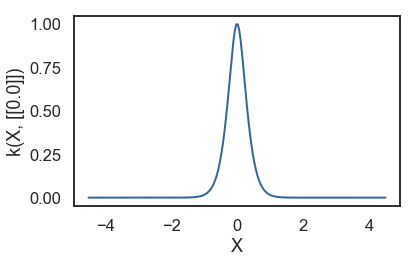

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # Comment this out if you don't have it
sns.set_style('white')
sns.set_context('talk')
import GPy
# The input dimension
dim = 1
# The variance of the covariance kernel
variance = 1.
# The lengthscale of the covariance kernel
ell = 0.3
# Generate the covariance object
k = GPy.kern.Matern52(dim, variance=variance, lengthscale=ell)
# Print it
print (k)
# and plot it
k.plot();

### Example 1: Plotting a covariance function
Remember:
> The covariance function $k(x,x')$ measures the similarity of $f(x)$ and $f(x')$.

The interactive tools provided, draw $k(\mathbf{x}, \mathbf{x}'=0)$ in one and two dimensions. 
Use them to answer the following questions:
+ What is the intuitive meaning of $\ell$?
+ What is the intuitive meaning of $v$?
+ There are many other covariance functions that we could be using. Try changing ``RBF`` to ``Exponential``. What changes do you nottice.
+ Repeat the previous steps on a 2D covariance function.
+ If you still have time, try a couple of other covariances, e.g., ``Matern32``, ``Matern52``.
+ If you still have time, explore ``help(GPy.kern)``.

In [3]:
from ipywidgets import interactive
def plot_kernel(variance=1., ell=0.3):
    k = GPy.kern.RBF(dim, variance=variance, lengthscale=ell)
    k.plot()
    plt.ylim(0, 10)
interactive(plot_kernel, variance=(1e-3, 10., 0.01), ell=(1e-3, 10., 0.01))

interactive(children=(FloatSlider(value=1.0, description='variance', max=10.0, min=0.001, step=0.01), FloatSli…

In [4]:
from ipywidgets import interactive
def plot_kernel(variance=1., ell1=0.3, ell2=0.3):
    k = GPy.kern.RBF(2, ARD=True, variance=variance,
                     lengthscale=[ell1, ell2])  # Notice that I just changed the dimension here
    k.plot()
interactive(plot_kernel, variance=(1e-3, 10., 0.01), ell1=(1e-3, 10., 0.01), ell2=(1e-3, 10., 0.01))

interactive(children=(FloatSlider(value=1.0, description='variance', max=10.0, min=0.001, step=0.01), FloatSli…

### Example 2: Properties of the covariance matrix
Let $\mathbf{x}_{1:n}$ be an arbitrary set of input points. The covariance matrix $\mathbf{K}\in\mathbb{R}^{n\times n}$ defined by:
$$
\mathbf{K} \equiv \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) = 
$$
$$
\begin{pmatrix}
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1, \mathbf{x}_n)\\
\vdots & \ddots & \vdots \\
k(\mathbf{x}_n, \mathbf{x}_1) & \dots & k(\mathbf{x}_n, \mathbf{x}_n) \end{pmatrix}
$$
must be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Mathematically this can be expressed in two equivalent ways:

+ For all vectors $\mathbf{v}\in\mathbb{R}^T$, we have:
$$
\mathbf{v}^t\mathbf{K}\mathbf{v} > 0,
$$
+ All the eigenvalues of $\mathbf{K}$ are positive.

Using the code provided:
+ Verify that the the sum of two covariance functions is a valid covariance function.
+ Verify that the product of two covariance functions is a valid covariance function.
+ Is the following function a covariance function:
$$
k(x, x') = k_1(x, x')k_2(x, x') + k_3(x, x') + k_4(x, x'),
$$
where all $k_i(x, x')$'s are covariance functions.
    ++ Yes, it is
+ What about:
$$
k(x, x') = k_1(x, x') / k_2(x, x')?
$$
    ++ Yes, it is also

> plotting eigenvalues of K
> they must all be positive


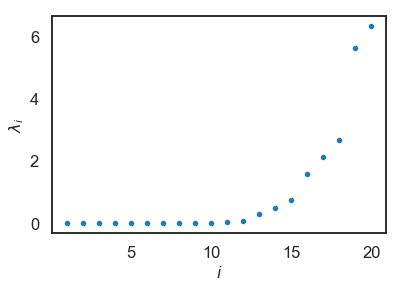

In [5]:
# Number of dimensions
dim = 1

# Number of input points
n = 20

# The lengthscale
ell = .1

# The variance 
variance = 1.

# The covariance function
k1 = GPy.kern.RBF(dim, lengthscale=ell, variance=variance)

# Draw a random set of inputs points in [0, 1]^dim
X = np.random.rand(n, dim)

# Evaluate the covariance matrix on these points
K = k1.K(X)

# Compute the eigenvalues of this matrix
eig_val, eig_vec = np.linalg.eigh(K)

# Plot the eigenvalues (they should all be positive)
print ('> plotting eigenvalues of K')
print ('> they must all be positive')
fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), eig_val, '.')
ax.set_xlabel('$i$', fontsize=16)
ax.set_ylabel('$\lambda_i$', fontsize=16);

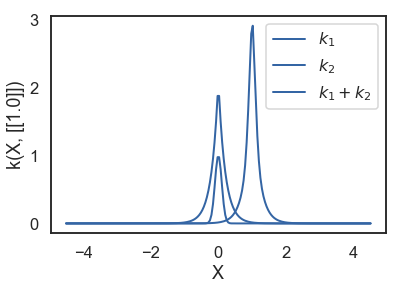

In [6]:
# Now create another (arbitrary) covariance function
k2 = GPy.kern.Exponential(dim, lengthscale=0.2, variance=2.1)

# Create a new covariance function that is the sum of these two:
k_new = k1 + k2

# Let's plot the new covariance
fig, ax = plt.subplots()
k1.plot(ax=ax, label='$k_1$')
k2.plot(ax=ax, label='$k_2$')
k_new.plot(ax=ax, label='$k_1 + k_2$')
plt.legend(fontsize=16);

> plotting eigenvalues of K
> they must all be positive


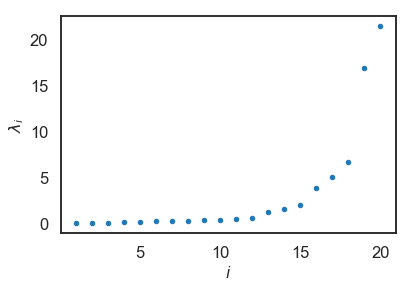

In [7]:
# If this is a valid covariance function, then it must be positive definite
# Compute the covariance matrix:
K_new = k_new.K(X)

# and its eigenvalues
eig_val_new, eig_vec_new = np.linalg.eigh(K_new)

# Plot the eigenvalues (they should all be positive)
print ('> plotting eigenvalues of K')
print ('> they must all be positive')
fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), eig_val_new, '.')
ax.set_xlabel('$i$', fontsize=16)
ax.set_ylabel('$\lambda_i$', fontsize=16);

### Example 3: Sampling from a Gaussian process

Samples from a Gaussian process are functions. But, functions are infinite dimensional objects?
We cannot sample directly from a GP....
However, if we are interested in the values of $f(\cdot)$ at any given set of test points $\mathbf{x}_{1:n} = \{\mathbf{x}_1,\dots,\mathbf{x}_b\}$, then we have that:
$$
\mathbf{f} | \mathbf{x}_{1:n} \sim \mathcal{N}\left(\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) \right),
$$
where all the quantities have been introduced above.
This is
What we are going to do is pick a dense set of points $\mathbf{x}_{1:n}\in\mathbb{R}^{n\times d}$
sample the value of the GP, $\mathbf{f} = (f(\mathbf{x}_1),\dots,f(\mathbf{x}_n))$ on these points.
We saw above that the probability density of $\mathbf{f}$ is just a multivariate normal
with a mean vector that is specified from the mean function and a covariance matrix
that is specified by the covariance function.
Therefore, all we need to know is how to sample from the multivariate normal.
This is how we do it:
+ Compute the Cholesky of $\mathbf{L}$:
$$
\mathbf{K} = \mathbf{L}\mathbf{L}^T.
$$
+ Draw $n$ random samples $\mathbf{z} = (z_1,\dots,z_n)$ independently from a standard normal.
+ Get one sample by:
$$
\mathbf{f} = \mathbf{m} + \mathbf{L}\mathbf{z}.
$$

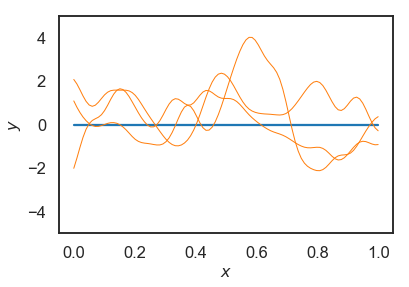

In [8]:
# To gaurantee reproducibility
np.random.seed(123999)

# Number of test points
num_test = 100

# Pick a covariance function
# k = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=0.10)
# k = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=0.10)
# k = GPy.kern.Exponential(input_dim=1, variance=1.0, lengthscale=0.10)
# k = GPy.kern.PeriodicMatern32(input_dim=1, variance=500., lengthscale=0.1, period=0.1)
k1 = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=0.05)
k2 = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=0.2)
k = k1 + k2

# Pick a mean function
mean_func = lambda x: np.zeros(x.shape)
# mean_func = lambda x: 5*x
# mean_func = lambda x: np.sin(5 * np.pi * x)

# Pick a bunch of points over which you want to sample the GP
X = np.linspace(0, 1, num_test)[:, None]

# Evaluate the mean function at X
m = mean_func(X)

# Compute the covariance function at these points
nugget = 1e-6 # This is a small number required for stability
C = k.K(X) + nugget * np.eye(X.shape[0])

# Compute the Cholesky of the covariance
# Notice that we need to do this only once
L = np.linalg.cholesky(C)

# Number of samples to take
num_samples = 3

# Take 3 samples from the GP and plot them:
fig, ax = plt.subplots()
# Plot the mean function
ax.plot(X, m)
for i in range(num_samples):
    z = np.random.randn(X.shape[0], 1)    # Draw from standard normal
    f = m + np.dot(L, z)                  # f = m + L * z
    ax.plot(X, f, color=sns.color_palette()[1], linewidth=1)
#ax.set_ylim(-6., 6.)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$y$', fontsize=16)
ax.set_ylim(-5, 5);

The solid line is the mean function and the dashed lines are 3 samples of   f . These don’t look like functions yet. This is because we have used only 10 test points to represent the GP.

### Questions

1. Edit the code above changing the number of test points ``num_test`` to 20, 50, 100. Rerun the example. How do your samples of   f look like now? Do they look more like functions to you? Imagine that the true nature of the GP appears when these test points become infinitely dense.

2. Edit the code above and change the random seed to an arbitrary integer (just make up one). Rerun the example and notice how the sampled functions change.

3. Edit the code above and change the variance first to 0.1 and then to 5 each time rerunning the example. Notice the values on the vertical axis of the plot. What happens to the sampled functions as you do this? What does the variance parameter of the SE control?

4. Edit the code above and now change the length-scale parameter first to 0.05 and then to 1. What happens to the sampled functions as you do this? What does the length- scale parameter of the SE control?

5. Now set the variance and the length-scale back to their original values (1. and 0.1, respectively). Edit the code and change the mean function to:
```
     mean_fun = lambda(x): 5 * x
```
Re-run the example. What do you observe? Try a couple more. For example, try:
```
     mean_fun = lambda(x): np.sin(5 * np.pi * x)
```

6. So far, all the samples we have seen are smooth. There is this theorem that says that the samples of the GP will be as smooth as the covariance function we use. Since the SE covariance is infinitely smooth, the samples we draw are infinitely smooth. The [Matern 3-2 covariance function](https://en.wikipedia.org/wiki/Matérn_covariance_function) is twice differentiable. Edit the code and
change ``RBF`` to ``Matern32``. Rerun the example. How smooth are the samples now?

7. The exponential covariance function is continuous but not differentiable. Edit the code and change ``RBF`` to ``Exponential``. Rerun the example. How smooth are the samples now?

8. The covariance function can also be used to model invariances. The periodic exponential covariance function is... a periodic covariance function. Edit line 29 and change ``RBF`` to 
```
k = GPy.kern.PeriodicMatern32(input_dim=1, variance=500., lengthscale=0.01, period=0.1)
```
Rerun the example. Do you notice the periodic pattern?

9. How can you encode the information that there are two lengthscales in $f(\cdot)$. There are many ways to do this.
Try summing or multiplying covariance functions.